<a href="https://colab.research.google.com/github/pagand/model_optimze_vessel/blob/yimeng/Modeling/fc_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers==4.30.0

import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import torch
import torch.nn as nn
from torch import nn, Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.metrics import r2_score, mean_squared_error
from torch.optim.lr_scheduler import StepLR
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel, TimeSeriesTransformerForPrediction
from transformers import AutoformerConfig, AutoformerModel, AutoformerForPrediction


from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
path = "drive/MyDrive/feature1.csv"
df = pd.read_csv(path)

NameError: ignored

In [ ]:
df["direction"] = df["direction"].apply(lambda x: 1 if x=="N-H" else 0)
df["MODE"] = df["MODE"].apply(lambda x: x-1)
# df = df[df["adversarial"]==0].drop("adversarial", axis=1)
# df = df[df["direction"]==1].drop("direction", axis=1)
df["Time2"] = df.groupby("trip_id")["Time"].rank(method="first", ascending=True)
df["is_weekday"] = df["is_weekday"].apply(lambda x: 1 if x==True else 0)

df["change_x_factor"] = np.cos((df.HEADING+90) * np.pi / 180)
df["change_y_factor"] = np.sin((df.HEADING-90) * np.pi / 180)
df["goal_long"] = df.direction.apply(lambda x: 0.9965111208024382 if x==1 else 0.0023259194650222526)
df["goal_lat"] = df.direction.apply(lambda x: 0.7729570345408661 if x==1 else 0)
df["prev_HEADING"] = df.HEADING.shift(periods=1)
df["turn"] = df.HEADING - df.prev_HEADING
# df["place_long"] = df["change_x_factor"] * df["SOG"]

In [ ]:
df["POWER"] = (df["POWER_1"]+df["POWER_2"])/2
df["SPEED"] = (df["SPEED_1"]+df["SPEED_2"])/2
df["THRUST"] = (df["THRUST_1"]+df["THRUST_2"])/2
df["TORQUE"] = (df["TORQUE_1"]+df["TORQUE_2"])/2
df["PITCH"] = (df["PITCH_1"]+df["PITCH_2"])/2
df["resist_ratio"] = (df["resist_ratio1"]+df["resist_ratio2"])/2
df["FLOWTEMPA"] = (df["ENGINE_1_FLOWTEMPA"]+df["ENGINE_2_FLOWTEMPA"])/2
df["FC"] = (df["ENGINE_1_FUEL_CONSUMPTION"]+df["ENGINE_2_FUEL_CONSUMPTION"])/2

df = df.drop(['PITCH_1', 'PITCH_2', 'POWER_1', 'POWER_2', 'SOG_SPEEDLOG_LONG',
       'SOG_SPEEDLOG_TRANS',  'THRUST_1',
       'THRUST_2', 'TORQUE_1', 'TORQUE_2', 'datetime',
       'resist_ratio1', 'resist_ratio2', 'SPEED_1', 'SPEED_2',
       'ENGINE_1_FLOWTEMPA', 'ENGINE_2_FLOWTEMPA',
       "ENGINE_1_FUEL_CONSUMPTION", "ENGINE_2_FUEL_CONSUMPTION"], axis=1)
# df = df.drop(["FLOWTEMPA", "PITCH", "POWER", "effective_wind_factor", "THRUST",
              # "pressure", "weekday", "Dati",], axis=1)

In [ ]:
df["dt"] = pd.to_datetime(df.Dati, format='%y%m%d_%H%M%S')
df["hour"] = df.dt.apply(lambda x: x.hour/24)

In [ ]:
# get one_hot for column
def one_hot(df, cols, normalize = True):
    for col in cols:
        dummy = pd.get_dummies(df[col],prefix=col, drop_first=True)
        columns = dummy.columns
        dummy[col] = 0
        i = 1
        for x in columns:
            # dummy["tmp"] = dummy[col]
            dummy[col] = dummy[col] + dummy[x]*i
            i = i*2
        max = dummy[col].max()
        if normalize:
            df[col] = dummy[col] / max
        else:
            df[col] = dummy[col]
    return df

In [ ]:
# standard scaler
# scaler2 = StandardScaler()
# power_scaler = PowerTransformer("yeo-johnson")
# df.FC = PowerTransformer("yeo-johnson").fit_transform(df[["FC"]])
# df.SOG = PowerTransformer("yeo-johnson").fit_transform(df[["SOG"]])
# df.SPEED = PowerTransformer("yeo-johnson").fit_transform(df[["SPEED"]])

minmax_scaler = MinMaxScaler((0,1))

transform_cols = [ 'current', 'rain', 'snowfall', "pressure", 'wind_force', "resist_ratio",
       'FC', "LATITUDE", 'LONGITUDE', 'SOG', "DEPTH", "SPEED"]
minmax_scaler = minmax_scaler.fit(df[transform_cols].values)
import pickle
pickle.dump(minmax_scaler, open('minmax_scaler.pkl', 'wb'))
df[transform_cols] = minmax_scaler.transform(df[transform_cols])
# df[transform_cols] = scaler2.fit_transform(df[transform_cols])
# df[["FC", "SOG", "SPEED"]] = df[["FC", "SOG", "SPEED"]].apply(lambda x: x**2)
# transform_cols
df[["FC2"]] = df[["FC"]].apply(lambda x: x**2)
df[["SOG4"]] = df[["SOG"]].apply(lambda x: x**4)

df["prev_SOG"] = df.SOG.shift(periods=1)
df["acceleration"] = ((df.SOG - df.prev_SOG))
df["distance"] = ((df["goal_long"]-df["LONGITUDE"])**2 + \
                             (df["goal_lat"]-df["LATITUDE"])**2 )**0.5

df["disp_x"] = df["change_x_factor"] * df["SOG"]
df["disp_y"] = df["change_y_factor"] * df["SOG"]

df = one_hot(df, ["season", "weathercode", "wind_direc"], normalize = True)
df = df[df["adversarial"]==0]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [ ]:
columns = df.columns.drop("Time2")
shifted_df = df.copy()
shifted_df[columns] = df[columns].shift(periods=5)

In [ ]:
class vessel_data(Dataset):
    def __init__(self, train = True, test=False, train_test_split = 0.7, rand_seed=1):
        ##########################inputs##################################
        #data_dir(string) - directory of the data#########################
        #size(int) - size of the images you want to use###################
        #train(boolean) - train data or test data#########################
        #train_test_split(float) - the portion of the data for training###
        #augment_data(boolean) - use data augmentation or not#############
        super(vessel_data, self).__init__()
        # todo
        #initialize the data class
        trips = list(df.trip_id.unique())
        self.train = train
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon

        # train_test_split
        random.seed(rand_seed)
        train_size = int(np.ceil(len(trips)*train_test_split))
        train_trips = random.sample(trips, k=train_size)
        if train:
            self.trips_id = train_trips
        else:
            test_trips = [ x for x in trips if x not in train_trips]
            valid_trips = random.sample(test_trips, k = int(np.ceil(len(trips)*((1-train_test_split)*.7))))
            if test==False:
                self.trips_id = valid_trips
            else:
                self.trips_id = [ x for x in test_trips if x not in valid_trips]
        # self.starting_dict = self.get_starting(df)

    # convert a df to tensor
    def df_to_tensor(self, df):
        if torch.cuda.is_available():
            device = torch.device('cuda:0')
        else:
            device = torch.device('cpu')
        return torch.from_numpy(df.values.astype("float")).float().to(device)

    # def get_starting(self, df):
    #     starting_dict = {}
    #     for trip_id in self.trips_id:
    #         data = df[df.trip_id==trip_id].reset_index(drop=True)
    #         starting = random.randint(0, len(data)-91)
    #         starting_dict[trip_id] = starting
    #         # print(starting)
    #     # print(starting_dict)
    #     return starting_dict

    def __getitem__(self, idx):
        #load corresponding trip id from index idx of your data
        trip_id = (self.trips_id[idx])
        # start = self.starting_dict[trip_id]
        # start_idx = self.starting_dict[trip_id] + (idx%3)*(self.prediction_horizon+self.sequence_length)
        data = df[df.trip_id==trip_id].reset_index(drop=True)
        shifted_data = shifted_df[df.trip_id==trip_id].reset_index(drop=True)

        starting = 0
        data = data.iloc[starting:starting+91]
        #get the needed episodes from the trips
        # end_idx = start_idx + self.sequence_length

        values = data[y_cols]
        time_features = data[time_feature + dynamic_real_feature]
        static_categorical_features = data.iloc[0][static_categorical_feature]
        future_time_features = shifted_data.iloc[starting:starting+91][time_feature + dynamic_real_feature]
        actions = data[["SPEED", "HEADING", "MODE", "turn"]]
        # print(static_categorical_features)
        # static_categorical_features = torch.tensor(static_categorical_features.values, dtype=torch.int64).to(device)
        # future_values = data.iloc[end_idx : (end_idx + self.prediction_horizon)][y_cols]
        # future_time_features = data.iloc[end_idx : (end_idx + self.prediction_horizon)][time_feature + dynamic_real_feature]
        # print(static_categorical_features.values)
        # static_categorical_features = torch.from_numpy(np.array(static_categorical_features.values).astype("int64")).to(device)

        return self.df_to_tensor(values), self.df_to_tensor(time_features), self.df_to_tensor(static_categorical_features), self.df_to_tensor(future_time_features), self.df_to_tensor(actions)

    def __len__(self):
        return len(self.trips_id)

In [ ]:
class vessel_data_test(Dataset):
    def __init__(self, train = True, test=False, train_test_split = 0.7, rand_seed=1):
        ##########################inputs##################################
        #data_dir(string) - directory of the data#########################
        #size(int) - size of the images you want to use###################
        #train(boolean) - train data or test data#########################
        #train_test_split(float) - the portion of the data for training###
        #augment_data(boolean) - use data augmentation or not#############
        super(vessel_data_test, self).__init__()
        # todo
        #initialize the data class
        trips = list(df.trip_id.unique())
        self.train = train
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon

        # train_test_split
        random.seed(rand_seed)
        train_size = int(np.ceil(len(trips)*train_test_split))
        train_trips = random.sample(trips, k=train_size)
        if train:
            self.trips_id = train_trips
        else:
            test_trips = [ x for x in trips if x not in train_trips]
            valid_trips = random.sample(test_trips, k = int(np.ceil(len(trips)*((1-train_test_split)*.7))))
            if test==False:
                self.trips_id = valid_trips
            else:
                self.trips_id = [ x for x in test_trips if x not in valid_trips]
        self.starting_dict = self.get_starting(df)

    # convert a df to tensor
    def df_to_tensor(self, df):
        if torch.cuda.is_available():
            device = torch.device('cuda:0')
        else:
            device = torch.device('cpu')
        return torch.from_numpy(df.values.astype("float")).float().to(device)

    def get_starting(self, df):
        starting_dict = {}
        for trip_id in self.trips_id:
            data = df[df.trip_id==trip_id].reset_index(drop=True)
            starting = random.randint(0, len(data)-91)
            starting_dict[trip_id] = starting
            # print(starting)
        # print(starting_dict)
        return starting_dict

    def __getitem__(self, idx):
        #load corresponding trip id from index idx of your data
        trip_id = (self.trips_id[idx//3])
        start = self.starting_dict[trip_id]
        start_idx = self.starting_dict[trip_id] + (idx%3)*(self.prediction_horizon+self.sequence_length)
        data = df[df.trip_id==trip_id].reset_index(drop=True)
        shifted_data = shifted_df[df.trip_id==trip_id].reset_index(drop=True)
        #get the needed episodes from the trips
        end_idx = start_idx + self.sequence_length

        past_values = data.iloc[start_idx : end_idx][y_cols]
        past_time_features = data.iloc[start_idx : end_idx][time_feature + dynamic_real_feature]
        static_categorical_features = data.iloc[0][static_categorical_feature]
        # print(static_categorical_features)
        # static_categorical_features = torch.tensor(static_categorical_features.values, dtype=torch.int64).to(device)
        future_values = data.iloc[end_idx : (end_idx + self.prediction_horizon)][y_cols]
        future_time_features = shifted_data.iloc[end_idx : (end_idx + self.prediction_horizon)][time_feature + dynamic_real_feature]
        future_time_features.loc[0, ["SPEED", "HEADING", "MODE", "turn"]] = data.loc[end_idx, ["SPEED", "HEADING", "MODE", "turn"]]
        # future_time_features = self.df_to_tensor(future_time_features)
        # future_time_features[:, 1:] = 0.5
        # print(static_categorical_features.values)
        # static_categorical_features = torch.from_numpy(np.array(static_categorical_features.values).astype("int64")).to(device)
        # print(static_categorical_features.shape)
        return self.df_to_tensor(past_values), self.df_to_tensor(past_time_features), self.df_to_tensor(static_categorical_features), \
               self.df_to_tensor(future_values), self.df_to_tensor(future_time_features)

    def __len__(self):
        return len(self.trips_id) * 3

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
# device = torch.device('cpu')

batch_size=256
sequence_length = 25
context_length = 18
prediction_horizon = 5
# criterion = Weighted_Loss()

time_feature = ["Time2"]
dynamic_real_feature = [ "SPEED", "HEADING", "MODE", "turn", "acceleration",
       "distance", 'current', 'rain', 'snowfall', 'wind_force', 'wind_direc', "resist_ratio", "FC", "SOG"]
static_categorical_feature = ["is_weekday", 'direction',"season", "hour"]
y_cols = ["FC2", "SOG4"]

# MODEL
configuration = TimeSeriesTransformerConfig(prediction_length=prediction_horizon,
        context_length=context_length, input_size=len(y_cols), num_time_features=len(time_feature),
        num_dynamic_real_features = len(dynamic_real_feature), num_static_real_features = len(static_categorical_feature),
        # cardinality = cardinality,
        return_dict = True)
model = TimeSeriesTransformerForPrediction(configuration).to(device)

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
trainset = vessel_data(train = True, train_test_split = 0.8, rand_seed=1)
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True, drop_last=True)

validset = vessel_data_test(train = False, train_test_split = 0.8, rand_seed=1)
validloader = DataLoader(validset, batch_size = batch_size, drop_last=True)


In [ ]:
# train the model
def train_model(trainloader, testloader, model, model_name = "transformer"):
    for epoch in range(n_epochs):
        epoch_loss = 0
        model.train()
        for _, data in enumerate(trainloader):
            values, time_features, static_categorical_features, future_features, actions  = data
            for t in range(sequence_length, values.shape[1]-2*prediction_horizon):
                for i in range(prediction_horizon):
                    future_time_features = future_features[:, t+i:t+prediction_horizon+i]
                    future_time_features[:, 0, 1:5] = actions[:, t+i, 0:4]
                    # future_values[:, :, 0] = values[:, t+i:t+prediction_horizon+i, 0]
                    future_values = values[:, t+i:t+prediction_horizon+i]
                    past_values = values[:, t-sequence_length+i: t]
                    if i!=0:
                        past_values = torch.concat([past_values, predicted[:, :i]], axis=1)
                    past_time_features = time_features[:, t-sequence_length+i: t+i]

                    # print(past_values.shape, past_time_features.shape)
                    optimizer.zero_grad()
                    past_observed_mask = torch.ones(past_values.shape).to(device)
                    prediction = model(past_values=past_values, past_time_features=past_time_features, static_real_features=static_categorical_features,
                                      past_observed_mask=past_observed_mask, future_values=future_values, future_time_features=future_time_features,
                                      output_hidden_states=True)
                    # loss = criterion(prediction.get("logits"), future_values)
                    loss = prediction.loss
                    epoch_loss += loss.item()
                    loss.backward()
                    optimizer.step()
                    predicted = model.generate(past_values=past_values, past_time_features=past_time_features, static_real_features=static_categorical_features,
                               past_observed_mask=past_observed_mask, future_time_features=future_time_features).sequences.mean(dim=1)

        print('Epoch %d / %d --- Loss: %.8f' % (epoch, n_epochs, epoch_loss / len(trainloader)/ 5 / (91-25)))
        mse, r2= evaluate_model(testloader, model)
        print('valid error: MSE: {}'.format(mse))
        print('valid r2: {}'.format(r2))
        path = "drive/MyDrive/{}_checkpoint{}.pt".format(model_name, epoch)
        torch.save(model.state_dict(), path)
    path = "drive/MyDrive/{}_final.pt".format(model_name, n_epochs)
    torch.save(model.state_dict(), path)


# evaluate the model
def evaluate_model(testloader, model, mode="valid", i=0):
    model.eval()
    to_draw = []
    predictions = []
    actuals = []
    i_val = i
    with torch.no_grad():
      for _, data in enumerate(testloader):
          past_values, past_time_features, static_categorical_features, future_values, future_time_features  = data
          past_observed_mask = torch.ones(past_values.shape).to(device)
          # return past_values, past_time_features, static_categorical_features, past_observed_mask, future_time_features
          outputs = model.generate(past_values=past_values, past_time_features=past_time_features, static_real_features=static_categorical_features,
                               past_observed_mask=past_observed_mask, future_time_features=future_time_features).sequences.mean(dim=1)
          # retrieve numpy array
          # print(outputs)
          yhat = outputs[:, 0, i_val].detach().cpu().numpy()
          actual = future_values[:, 0, i_val].detach().cpu().numpy()
          # store
          actual = actual.reshape([-1, 1])
          yhat = yhat.reshape([-1,1])
          # store
          predictions.append(yhat)
          actuals.append(actual)

    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    if mode=="test":
      return mean_squared_error(actuals, predictions), r2_score(actuals, predictions), predictions, actuals
    # calculate mse
    return mean_squared_error(actuals, predictions), r2_score(actuals, predictions)
    #actuals[:20], predictions[:20]

In [ ]:
# model.load_state_dict(torch.load("drive/MyDrive/fc_1_checkpoint9.pt"))

<All keys matched successfully>

In [ ]:
iter = 1

In [ ]:
# torch.save(model.state_dict(), "sumup_8_checkpoint9.pt")

In [ ]:
iter = iter+1
print(iter)
n_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=  5e-6)
train_model(trainloader, validloader, model, "fc_{}".format(iter))

2
Epoch 0 / 10 --- Loss: -4.60973544
valid error: MSE: 0.004902037791907787
valid r2: 0.7925603417477003
Epoch 1 / 10 --- Loss: -4.60635741
valid error: MSE: 0.004817083012312651
valid r2: 0.7961553710051542
Epoch 2 / 10 --- Loss: -4.60870121
valid error: MSE: 0.004731833003461361
valid r2: 0.799762910778314
Epoch 3 / 10 --- Loss: -4.61055660
valid error: MSE: 0.004825599491596222
valid r2: 0.7957949935694465
Epoch 4 / 10 --- Loss: -4.60932815
valid error: MSE: 0.004837028682231903
valid r2: 0.7953113355468981
Epoch 5 / 10 --- Loss: -4.61392242
valid error: MSE: 0.00477118045091629
valid r2: 0.7980978301710464
Epoch 6 / 10 --- Loss: -4.62124113
valid error: MSE: 0.004839526955038309
valid r2: 0.7952056107078483
Epoch 7 / 10 --- Loss: -4.60633239
valid error: MSE: 0.006216845009475946
valid r2: 0.7369216140202419
Epoch 8 / 10 --- Loss: -4.61963292
valid error: MSE: 0.005087085533887148
valid r2: 0.7847296795067743
Epoch 9 / 10 --- Loss: -4.61928752
valid error: MSE: 0.004792480729520321

In [ ]:
# y_cols = ['FC', 'SOG']
testset = vessel_data_test(train = False, test=True, train_test_split = 0.8, rand_seed=1)
testloader = DataLoader(testset, batch_size = batch_size, drop_last=True)
#FC
#model
evaluate_model(testloader, model, mode="valid",)


(0.004782996, 0.7885443346972978)

In [ ]:
#SOG
evaluate_model(testloader, model, mode="valid", i=1)

(0.0068994286, 0.6313301557335487)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider, Button, RadioButtons


def plot(batch_i=0, seq_i=0):
  actual = np.concatenate([to_draw[batch_i]["past"][seq_i][[-1]], to_draw[batch_i]["acutal"][seq_i]])
  predicted = np.concatenate([to_draw[batch_i]["past"][seq_i][[-1]], to_draw[batch_i]["predicted"][seq_i]])
  plt.plot(to_draw[batch_i]["past"][seq_i], label='past'.format(i=0))
  plt.plot(range(24,30), actual, label='actual'.format(i=1))
  plt.plot(range(24,30), predicted, label='predicted'.format(i=2))
  plt.legend(loc='best')
  plt.show()

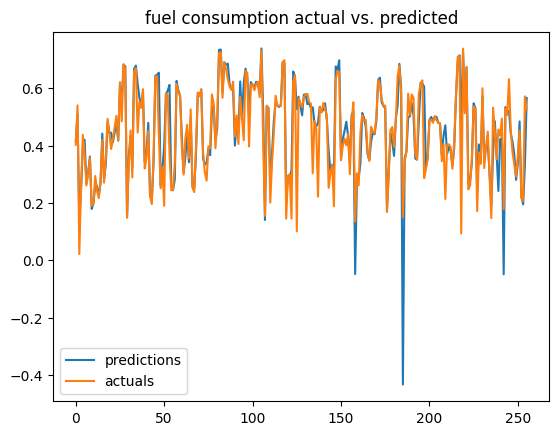

In [ ]:
_,_, to_draw, predictions, actuals = evaluate_model(testloader, model, mode="test", i=0)
# to_draw[0]

predictions, actuals

plt.plot(predictions, label='predictions'.format(i=2))
plt.plot(actuals, label='actuals'.format(i=1))
plt.legend(loc='best')
# plt.ylim([0, 1])
plt.title("fuel consumption actual vs. predicted")
plt.show()

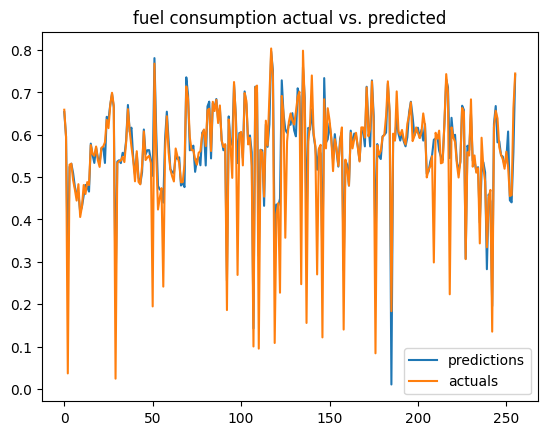

In [ ]:
_,_, to_draw, predictions, actuals = evaluate_model(testloader, model, mode="test", i=1)
# to_draw[0]

predictions, actuals

plt.plot(predictions, label='predictions'.format(i=2))
plt.plot(actuals, label='actuals'.format(i=1))
plt.legend(loc='best')
# plt.ylim([-2, 2])
plt.title("fuel consumption actual vs. predicted")
plt.show()

In [ ]:
df.FC